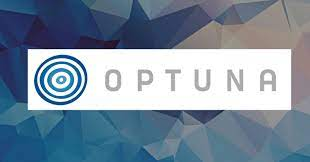

# Usual advices :
* XGB and LGB have 2 kind of API, the original and the scikit learn API, with some differences. 
* Prepare your data first (feature engineering, encoding, missing value...)
* Be close as possible your CV strategy
* Choose carefully your parameter range (according to the dataset)
* Choose the correct metric and type of target (classification, regression)
* Check whether your best parameters found are not to close to the range you gave (don't limit the tuning)
* Use GPU when possible
* Adapt the size of the dataset or CV strategy to the volume of the data

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv')
TARGET = 'num_sold'
FEATURES = train.columns.difference([TARGET,'date'])

<h1> Minimal preprocessing

In [ ]:
for feature in ['country', 'product', 'store'] :
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature])
    
train['date'] = pd.to_datetime(train['date'])
train.head(3)

<h1> CatBoostRegressor

In [ ]:
N_split = 2
kf = KFold(n_splits=N_split)

import optuna

def objective(trial):
    params = {
                #'iterations' : 10000, replaced by early stopping
                'eval_metric': 'SMAPE', 
                'use_best_model': True,
                'random_seed' : 1,
                'learning_rate' :trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                "depth": trial.suggest_int("depth", 1, 15),
                'l2_leaf_reg' :trial.suggest_loguniform('l2_leaf_reg', 1e-8, 20),
                'random_strength' : trial.suggest_loguniform('random_strength', 1, 50),
                'grow_policy':trial.suggest_categorical ('grow_policy', ['Lossguide','SymmetricTree']),
                'max_bin': trial.suggest_int("max_bin", 20, 500),
                'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 1, 100),
                "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"])
            }
    
    if params['grow_policy'] == 'Lossguide':
        params['max_leaves']:trial.suggest_int('max_leaves', 1, 100)
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    
    score_list = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(train, train[TARGET])):
        X_tr = train.loc[train_idx][FEATURES]
        X_va = train.iloc[val_idx][FEATURES]
        
        # Preprocess the data
        X_tr_f = X_tr # Use the correct preprocessing if required (normalization...)
        y_tr = train[TARGET].loc[train_idx].values

        X_va_f = X_va # Use the correct preprocessing if required (normalization...)
        y_va = train[TARGET].loc[val_idx].values

        # Train the model
        model = CatBoostRegressor(**params) 
        model.fit(        
                X_tr_f,
                y_tr,
                eval_set =[( X_va_f,y_va)],
                verbose =0,
                early_stopping_rounds = 200)

        # Predictions
        y_va_pred = model.predict(X_va_f)
        score = mean_squared_error(y_va, y_va_pred,squared = True)
        score_list.append(score)
        
    return sum(score_list) / len(score_list)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

<h1> XGBoost

In [ ]:
N_split = 2
kf = KFold(n_splits=N_split)

import optuna

def objective(trial):
   
    params = {
            'tree_method': 'hist',
            'grow_policy' : trial.suggest_categorical ('grow_policy', ['lossguide','depthwise']),
            'learning_rate':trial.suggest_loguniform('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 20),# a virer avec'depthwise'
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1, 10),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-15, 10.0),
            'max_delta_step':trial.suggest_int('max_delta_step', 1, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'colsample_bytree':trial.suggest_loguniform('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
            'seed':1
                }
    if params['grow_policy'] == 'lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 1, 100)   
        
        
    score_list = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(train, train[TARGET])):
        X_tr = train.loc[train_idx][FEATURES]
        X_va = train.iloc[val_idx][FEATURES]
        
        # Preprocess the data
        X_tr_f = X_tr # Use the correct preprocessing if required (normalization...)
        y_tr = train[TARGET].loc[train_idx].values
        data_tr = xgb.DMatrix(X_tr_f, label=y_tr)

        X_va_f = X_va # Use the correct preprocessing if required (normalization...)
        y_va = train[TARGET].loc[val_idx].values
        data_va = xgb.DMatrix(X_va_f, label=y_va)
        evallist = [(data_va, 'eval'), (data_tr, 'train')]

        # Train the model
        model = xgb.train(params, 
                          data_tr,
                          num_boost_round=2000,
                          evals = evallist,
                          verbose_eval=0,
                          early_stopping_rounds = 200)

        # Predictions
        y_va_pred = model.predict(data_va)
        score = mean_squared_error(y_va, y_va_pred,squared = True)
        score_list.append(score)
        
    return sum(score_list) / len(score_list)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

<h1> LGBMRegressor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

N_split = 2
kf = KFold(n_splits=N_split)

import optuna

def objective(trial):
    params = {
            'objective': 'regression',
            'metric': 'mse',
            'learning_rate': trial.suggest_float("learning_rate", 0.04,0.4),
            'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
            'colsample_bytree':trial.suggest_float("colsample", 0.1,0.3),
            'subsample': trial.suggest_float("subsample", 0.1,0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 100),
            'min_child_samples': trial.suggest_int('min_child_samples', 3, 2000),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
            'cat_smooth':trial.suggest_int('cat_smooth', 1, 100)
            }
    
    score_list = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(train, train[TARGET])):
        X_tr = train.loc[train_idx][FEATURES]
        X_va = train.iloc[val_idx][FEATURES]
        
        # Preprocess the data
        X_tr_f = X_tr # Use the correct preprocessing if required (normalization...)
        y_tr = train[TARGET].loc[train_idx].values

        X_va_f = X_va # Use the correct preprocessing if required (normalization...)
        y_va = train[TARGET].loc[val_idx].values

        # Train the model
        model = lgb.LGBMRegressor(**params) 
        model.fit(        
                X_tr_f,
                y_tr,
                eval_set =[( X_va_f,y_va)],
                verbose =0,
                early_stopping_rounds = 200)

        # Predictions
        y_va_pred = model.predict(X_va_f)
        score = mean_squared_error(y_va, y_va_pred,squared = True)
        score_list.append(score)
        
    return sum(score_list) / len(score_list)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)